In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error

In [162]:
df = pd.read_csv("SupplyChainEmissionFactorsforUSIndustriesCommodities(2015_Summary_Industry).csv")
print("Shape:",df.shape)
df.head()

Shape: (264, 13)


,Industry Code,Industry Name,Substance,Unit,Supply Chain Emission Factors without Margins,Margins of Supply Chain Emission Factors,Supply Chain Emission Factors with Margins,Unnamed: 7,DQ ReliabilityScore of Factors without Margins,DQ TemporalCorrelation of Factors without Margins,DQ GeographicalCorrelation of Factors without Margins,DQ TechnologicalCorrelation of Factors without Margins,DQ DataCollection of Factors without Margins
0,111CA,Farms,carbon dioxide,"kg/2018 USD, purchaser price",Supply Chain Emission Factors without Margins,0.041,0.465,NaN,4,2,1,4,1
1,111CA,Farms,methane,"kg/2018 USD, purchaser price",0.023,0.000,0.023,NaN,3,2,1,1,1
2,111CA,Farms,nitrous oxide,"kg/2018 USD, purchaser price",0.002,0.000,0.002,NaN,4,2,1,4,1
3,111CA,Farms,other GHGs,"kg CO2e/2018 USD, purchaser price",0.004,0.000,0.004,NaN,3,2,1,4,1
4,113FF,"Forestry, fishing, and related activities",carbon dioxide,"kg/2018 USD, purchaser price",0.184,0.017,0.201,NaN,4,2,1,4,1


In [164]:
df_clean = df[1:].copy() 
df_clean['Supply Chain Emission Factors with Margins'] = pd.to_numeric(df_clean['Supply Chain Emission Factors with Margins'], errors='coerce')
df_clean['Margins of Supply Chain Emission Factors'] = pd.to_numeric(df_clean['Margins of Supply Chain Emission Factors'], errors='coerce')
df_clean = df_clean.dropna(subset=['Supply Chain Emission Factors with Margins'])

X = df_clean[['Industry Code', 'Industry Name', 'Substance']]
y = df_clean['Supply Chain Emission Factors with Margins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['Industry Code', 'Industry Name', 'Substance']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('regressor', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}

for model, metrics in results.items():
    print(f"\n{model} Results:")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  MAE : {metrics['MAE']:.4f}")
    print(f"  R²  : {metrics['R²']:.4f}")


Linear Regression Results:
  RMSE: 0.4502
  MAE : 0.1444
  R²  : 0.0853

Decision Tree Results:
  RMSE: 0.4610
  MAE : 0.0932
  R²  : 0.0408

Random Forest Results:
  RMSE: 0.4613
  MAE : 0.0951
  R²  : 0.0399


In [166]:
print(residuals.describe())

count    53.000000
mean      0.083745
std       0.457932
min      -0.096240
25%      -0.000990
50%       0.000010
75%       0.007240
max       3.311760
Name: Supply Chain Emission Factors with Margins, dtype: float64


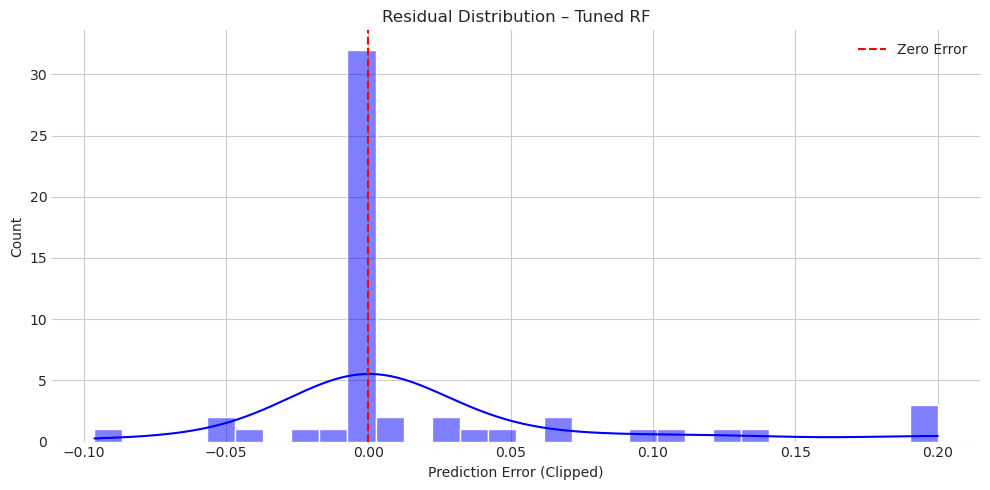

In [178]:
plt.figure(figsize=(10, 5))

sns.histplot(residuals.clip(-0.2, 0.2), kde=True, color='blue', binwidth=0.01)

plt.title("Residual Distribution – Tuned RF")
plt.xlabel("Prediction Error (Clipped)")
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.legend()
plt.tight_layout()
plt.show()

In [170]:
from sklearn.preprocessing import StandardScaler

categorical_cols = ['Industry Code', 'Industry Name', 'Substance']  
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

model = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_pred = best_model.predict(X_test)


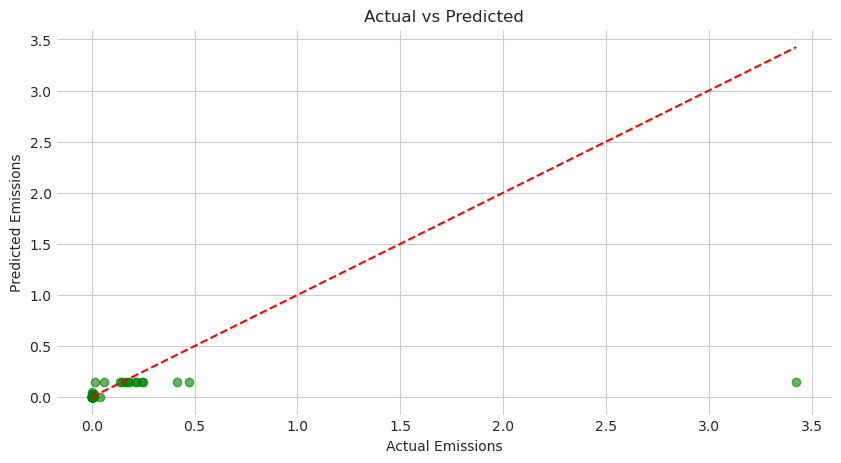

In [172]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, best_pred, color='green', alpha=0.6)

min_val = min(min(y_test), min(best_pred))
max_val = max(max(y_test), max(best_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')  # y = x line

plt.xlabel("Actual Emissions")
plt.ylabel("Predicted Emissions")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()

In [174]:
import joblib
joblib.dump(best_pred, "best_random_forest_model.pkl")
print("Model saved as best_random_forest_model")

Model saved as best_random_forest_model
